# Простые классификаторы MNIST. Часть 1.

Пример обучения простой полносвязной сети для классификации изображений MNIST.

## Импорт библиотек

Для начала импортируем всё необходимое для создания нейронной сети. Для построения графиков будем использовать matplotlib.

In [1]:
import keras
from keras.datasets import mnist # Датасет
from keras.models import Sequential # Базовый класс для создания нейронной сети
from keras.layers import Input, Dense # Два вида слоёв нейронное сети, которые будут использоваться
from keras.utils import np_utils # Утилиты для one-hot encoding

import numpy as np
import matplotlib.pyplot as plt

print(keras.__version__)

2.4.3


Выполним загрузку данных.

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


## Изучение данных

Давайте посмотрим на формат данных перед обучением модели. Воспользовавшись shape мы видим, что в тренировочном датасете 60 000 изображений, каждое размером 28 x 28 пикселей. 

In [4]:
train_images.shape

(60000, 28, 28)

Соответственно, в тренировочном сете 60 000 меток:

In [5]:
len(train_labels)

60000

Проверочный сет содержит 10,000 изображений, каждое - также 28 на 28 пикселей:

In [6]:
test_images.shape

(10000, 28, 28)

И в проверочном сете - ровно 10,000 меток:

In [7]:
len(test_labels)

10000

## Предобработка данных

Данные должны быть предобработаны перед обучением нейросети. Если вы посмотрите на первое изображение в тренировочном сете вы увидите, что значения пикселей находятся в диапазоне от 0 до 255:

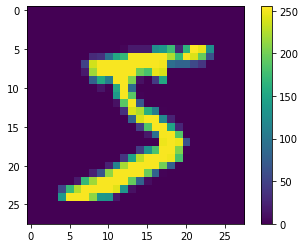

In [8]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Мы масштабируем эти значения к диапазону от 0 до 1 перед тем как скормить их нейросети. Для этого мы поделим значения на 255. Важно, чтобы тренировочный сет и проверочный сет были предобработаны одинаково:

In [9]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Чтобы убедиться, что данные в правильном формате и мы готовы построить и обучить нейросеть, выведем на экран первые 25 изображений из тренировочного сета и отобразим под ними наименования их классов.

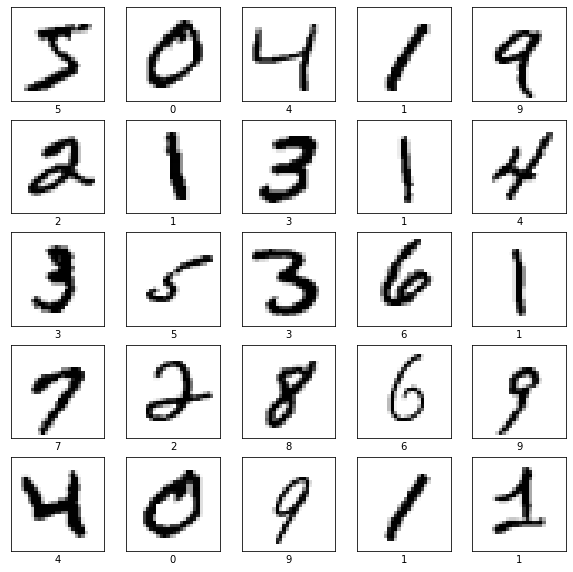

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

### Добавим валидационные данные

Отрежем от основных данных часть изображений: 1000 картинок.

In [11]:
validation_images = train_images[:1000]
validation_labels = train_labels[:1000]

train_images = train_images[1000:]
train_labels = train_labels[1000:]

## Построение простой модели

Построение модели нейронной сети требует правильной конфигурации каждого слоя, и последующей компиляции модели.

### Настроим слои

Создадим простую нейронную сеть с одним скрытым слоем

In [12]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Первый слой этой сети - `tf.keras.layers.Flatten`, преобразует формат изображения из двумерного массива (28 на 28 пикселей) в одномерный (размерностью 28 * 28 = 784 пикселя). Слой извлекает строки пикселей из изображения и выстраивает их в один ряд. Этот слой не имеет параметров для обучения; он только переформатирует данные.

После разложения пикселей, нейросеть содержит два слоя `tf.keras.layers.Dense`. Это полносвязные нейронные слои. Первый Dense слой состоит из 128 узлов (или нейронов). Второй (и последний) 10-узловой softmax слой возвращает массив из 10 вероятностных оценок дающих в сумме 1. Каждый узел содержит оценку указывающую вероятность принадлежности изображения к одному из 10 классов.

### Скомпилируем модель

Прежде чем модель будет готова для обучения, нам нужно указать еще несколько параметров. Они добавляются на шаге compile модели:

- Функция потерь (Loss function) — измеряет точность модели во время обучения. Мы хотим минимизировать эту функцию чтоб "направить" модель в верном направлении.
- Оптимизатор (Optimizer) — показывает каким образом обновляется модель на основе входных данных и функции потерь.
- Метрики (Metrics) — используются для мониторинга тренировки и тестирования модели. Наш пример использует метрику accuracy равную доле правильно классифицированных изображений.


In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Обучим модель

Обучение модели нейронной сети требует выполнения следующих шагов::

1. Подайте тренировочный данные в модель. В этом примере тренировочные данные это массивы train_images и train_labels.
2. Модель учится ассоциировать изображения с правильными классами.
3. 
Мы просим модель сделать прогнозы для проверочных данных, в этом примере массив test_images. Мы проверяем, соответствуют ли предсказанные классы меткам из массива test_labels.

Для начала обучения, вызовите метод model.fit, который называется так, поскольку он "тренирует (fits)" модель на тренировочных данных:

In [13]:
history = model.fit(
    train_images, 
    train_labels, 
    epochs=5, 
    batch_size=128, 
    validation_data=(validation_images, validation_labels)
)

Epoch 1/5
461/461 [==============================] - 1s 2ms/step - loss: 0.3569 - accuracy: 0.9010 - val_loss: 0.2109 - val_accuracy: 0.9450
Epoch 2/5
461/461 [==============================] - 0s 983us/step - loss: 0.1613 - accuracy: 0.9537 - val_loss: 0.1443 - val_accuracy: 0.9650
Epoch 3/5
461/461 [==============================] - 1s 2ms/step - loss: 0.1169 - accuracy: 0.9670 - val_loss: 0.1281 - val_accuracy: 0.9640
Epoch 4/5
461/461 [==============================] - 1s 2ms/step - loss: 0.0907 - accuracy: 0.9741 - val_loss: 0.1115 - val_accuracy: 0.9670
Epoch 5/5
461/461 [==============================] - 0s 1ms/step - loss: 0.0729 - accuracy: 0.9788 - val_loss: 0.0964 - val_accuracy: 0.9680


В процессе обучения модели отображаются метрики потери (loss) и точности (accuracy). Эта модель достигает на тренировочных данных точности равной приблизительно 0.99 (99%).

### Оценим точность

Далее, сравните какую точность модель покажет на проверчном датасете:

In [14]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

313/313 - 0s - loss: 0.0842 - accuracy: 0.9732

Точность на проверочных данных: 0.9732000231742859


Полученная на проверочном сете точность оказалась немного ниже, чем на тренировочном. Этот разрыв между точностью на тренировке и тесте является примером переобучения (overfitting). Переобучение возникает, когда модель машинного обучения показывает на новых данных худший результат, чем на тех, на которых она обучалась.

Давайте посмотрим на график обучения, сравнив точность на тренировочных и валидационных данных на каждой эпохе

In [15]:
def show_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

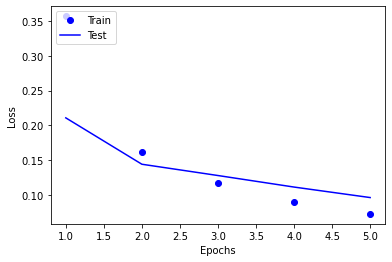

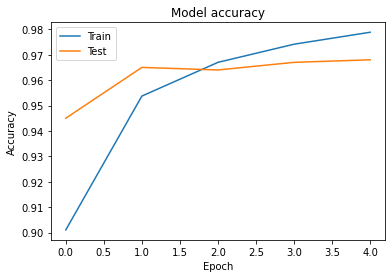

In [16]:
show_loss(history)

### Сделаем предсказания

Теперь, когда модель обучена, мы можем использовать ее чтобы сделать предсказания по поводу нескольких изображений:

In [17]:
predictions = model.predict(test_images)

Здесь полученная модель предсказала класс одежды для каждого изображения в проверочном датасете. Давайте посмотрим на первое предсказание:

In [18]:
predictions[0]

array([1.77283334e-06, 2.34421307e-07, 1.20610675e-04, 3.52103962e-03,
       1.09979803e-08, 1.61625267e-05, 2.27181260e-10, 9.96310174e-01,
       9.89196542e-06, 2.02085721e-05], dtype=float32)

Прогноз представляет из себя массив из 10 чисел. Они описывают "уверенность" (confidence) модели в том, насколько изображение соответствует каждому из 10 разных видов одежды. Мы можем посмотреть какой метке соответствует максимальное значение:

In [19]:
np.argmax(predictions[0])

7

Проверим правильность предсказания модели:

In [20]:
test_labels[0]

7

### Построим графики

Мы можем построить график, чтобы взглянуть на полный набор из 10 предсказаний классов.

In [21]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


Давайте посмотрим на нулевое изображение, предсказание и массив предсказаний.

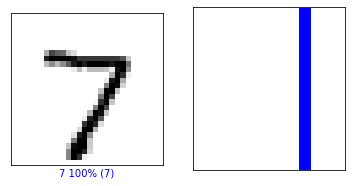

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

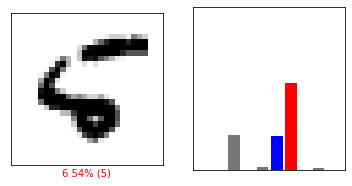

In [23]:
i = 8
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

Давайте посмотрим несколько изображений с их прогнозами. Цвет верных предсказаний синий, а неверных - красный. Число это процент уверенности (от 100) для предсказанной метки. Отметим, что модель может ошибаться даже если она очень уверена.

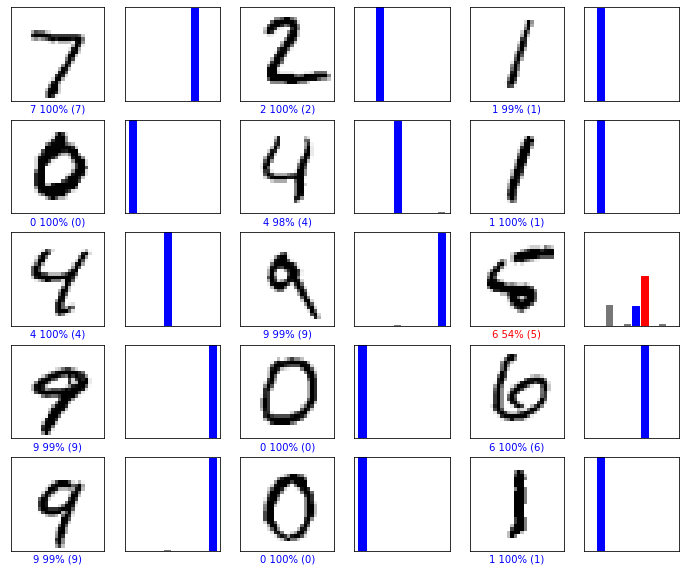

In [24]:
# Отображаем первые X тестовых изображений, их предсказанную и настоящую метки.
# Корректные предсказания окрашиваем в синий цвет, ошибочные в красный.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()